# Task 2:  OSATS Multi-Label Classification

This notebook implements a deep learning aproach for Task 2. The objective is Predict 8 OSATS scores (ranging from 0 to 4) for each surgical video

We will use the previously processed data, as well as those made available by the teacher.

- Input: `.npz` files with `features` of shape `(~900, 384,20,20)` flatenned, representing 900 selected frames per video as well as 384 feature maps with 20x20 of dimension

- Targets: vector of 8 integers per video (one per OSATS criterion)

**This notebook was disregarded but kept in the repository.**


### 1. Inicialization

In [1]:
# Imports
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from torch import Tensor
from torch.nn import CrossEntropyLoss
from torch.nn import Sequential, Linear, ReLU, LSTM, Module, Conv1d
from torch.nn import Parameter, LayerNorm, TransformerEncoderLayer, TransformerEncoder, Dropout, ModuleList

from torch.utils.data import Subset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split


from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

from collections import Counter
from livelossplot import PlotLosses

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
         for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

device = get_default_device()   
print(device)

cuda


In [8]:
# File Paths
PATH_DATA = "../../OSS_dataset/Train/numpy_files_3fps/"
PATH_LABELS = "../../OSS_dataset/Train/OSATS.csv"

PREDICTIONS_PATH = "results/osats_02_results.csv"
GROUND_TRUTH_PATH = "results/ground_truth.csv"

OUTPUT_FOLDER = "./results/"

In [9]:
# Constants And Seed
SEED = 42
BATCH_SIZE = 8
NUM_CLASSES = 5

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

### 2. Data Preparation 

In [23]:
class OSATSDataset(Dataset):
    def __init__(self, path_data, path_label, num_frames=900):
        self.num_frames = num_frames
        self.files = sorted([
            os.path.join(path_data, f)
            for f in os.listdir(path_data)
            if f.endswith(".npz")
        ])
        
        df_labels = pd.read_csv(path_label, sep=';')
        df_labels.set_index('VIDEO', inplace=True)
        
        grouped = df_labels.groupby(df_labels.index)
        
        self.osats_cols = [
            "OSATS_RESPECT", "OSATS_MOTION", "OSATS_INSTRUMENT", "OSATS_SUTURE",
            "OSATS_FLOW", "OSATS_KNOWLEDGE", "OSATS_PERFORMANCE", "OSATS_FINAL_QUALITY"
        ]

        self.labels = {
            video_name: [int(round(group[col].mean())) - 1 for col in self.osats_cols]
            for video_name, group in grouped
        }

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        video_name = os.path.splitext(os.path.basename(path))[0]
    
        data = np.load(path)
        flat = data["arr_0"]
    
        frame_dim = 384 * 20 * 20
        n_frames = flat.shape[0] // frame_dim
    
        video = flat.reshape(n_frames, 384, 20, 20)
    
        
        if n_frames >= self.num_frames:
            video = video[:self.num_frames]
        else:
            raise ValueError(f"{video_name}doest have enough frames")
    
        video_tensor = torch.tensor(video, dtype=torch.float32)
        video_tensor = F.avg_pool2d(video_tensor, kernel_size=2)  # (num_frames, 384, 10, 10)
    
        label = torch.tensor(self.labels[video_name], dtype=torch.long)  # (8,)
    
        return video_tensor, label, video_name


In [24]:
def osats_prepare_data_loaders(test = 0.2, val = 0.1):
    generator = torch.Generator().manual_seed(SEED)

    full_dataset = OSATSDataset(path_data=PATH_DATA,path_label=PATH_LABELS)    
    
    total_len = len(full_dataset)
    val_size = int(val * total_len)
    test_size = int(test * total_len)
    train_size = total_len - val_size - test_size

    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size], generator=generator)
    
    # DataLoaders 
    train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dl   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_dl  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # DataLoaders without Batching
    train_dl_all = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
    val_dl_all   = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
    test_dl_all  = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

    return train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all


In [25]:
train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all = osats_prepare_data_loaders()

#### 2.1 Visualize Data

In [28]:
def visualize_dataset(train, test, val):
    print(f"Casos de Treino: {len(train.dataset)}")
    print(f"Casos de Validação: {len(val.dataset)}")
    print(f"Casos de Teste: {len(test.dataset)}\n")

    x, y, _ = next(iter(train)) 
    print(f"(TREINO): Shape tensor batch -> input: {x.shape}, output: {y.shape}")
    
    x, y, _ = next(iter(val)) 
    print(f"(VAL)   : Shape tensor batch -> input: {x.shape}, output: {y.shape}")

    x, y, _ = next(iter(test))
    print(f"(TESTE) : Shape tensor batch -> input: {x.shape}, output: {y.shape}\n")
    
    print(f'Valor maximo x:{torch.max(x)}\nValor mínimo x:{torch.min(x)}\n')
    print(f'Valor maximo y:{torch.max(y)}\nValor mínimo y:{torch.min(y)}\n')


In [29]:
visualize_dataset(train_dl, test_dl, val_dl)

Casos de Treino: 221
Casos de Validação: 31
Casos de Teste: 62

(TREINO): Shape tensor batch -> input: torch.Size([8, 900, 384, 10, 10]), output: torch.Size([8, 8])
(VAL)   : Shape tensor batch -> input: torch.Size([8, 900, 384, 10, 10]), output: torch.Size([8, 8])
(TESTE) : Shape tensor batch -> input: torch.Size([8, 900, 384, 10, 10]), output: torch.Size([8, 8])

Valor maximo x:4.710690498352051
Valor mínimo x:-0.27846354246139526

Valor maximo y:3
Valor mínimo y:0



### 3. Model

#### Model Architecture: OSATSModel_02– Transformer-based Model

This model processes spatio-temporal video data using a Transformer encoder and is designed for multi-label, multi-class classification of the 8 OSATS criteria.

#### Input
- Shape: `[B, 900, 384, 10, 10]`  
  A sequence of 900 frames per video, each with 384 feature maps of size 10×10.

#### Architecture

- **Flattening + Embedding**:
  - Each frame is flattened into a vector of size `384 × 10 × 10`.
  - Passed through a `Linear` layer to project into `d_model` (default: 256).
  - `LayerNorm` is applied to stabilize the embedding.

- **CLS Token + Positional Encoding**:
  - A learnable `[CLS]` token is prepended to the sequence.
  - Positional embeddings are added to encode temporal order.

- **Transformer Encoder**:
  - Stack of `num_layers` (default: 3) Transformer encoder layers.
  - Each layer uses `nhead` attention heads (default: 4), feedforward size `d_model * 4`, and dropout (default: 0.3).
  - Operates in `batch_first` mode.

- **Classification Head**:
  - Takes the output corresponding to the `[CLS]` token.
  - Applies `LayerNorm`, `Dropout`, and a `Linear` layer projecting to `8 × 5 = 40` outputs.
  - Reshaped to `[B, 8, 5]`, where each of the 8 OSATS criteria is classified into 5 possible scores (0–4).

#### Output
- Shape: `[B, 8, 5]`  
  Logits for each of the 8 OSATS domains, each with 5 class probabilities.

In [30]:
class OSATSModel_02(Module):
    def __init__(self, input_channels=384, height=10, width=10, seq_len=900, d_model=256, nhead=4, num_layers=3, num_targets=8, num_classes=5, dropout=0.3):
        super().__init__()

        self.seq_len = seq_len
        self.num_targets = num_targets
        self.num_classes = num_classes

        self.flatten_dim = input_channels * height * width
        self.embedding = Linear(self.flatten_dim, d_model)
        self.embedding_norm = LayerNorm(d_model)  # LayerNorm 

        self.cls_token = Parameter(torch.randn(1, 1, d_model))
        self.pos_embedding = Parameter(torch.randn(1, seq_len + 1, d_model))  # +1 to CLS

        encoder_layer = TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.head = Sequential(
            LayerNorm(d_model),
            Dropout(dropout),
            Linear(d_model, num_targets * num_classes)
        )

    def forward(self, x):  # x: [B, 900, 384, 10, 10]
        B, T, C, H, W = x.shape

        x = x.view(B, T, -1)                # [B, 900, flatten_dim]
        x = self.embedding(x)              # [B, 900, d_model]
        x = self.embedding_norm(x)      
        cls_token = self.cls_token.expand(B, 1, -1)     # [B, 1, d_model]
        x = torch.cat([cls_token, x], dim=1)            # [B, 901, d_model]
        x = x + self.pos_embedding[:, :x.size(1)]       

        x = self.transformer(x)                         # [B, 901, d_model]
        cls_out = x[:, 0]                               # [B, d_model]

        logits = self.head(cls_out)                     # [B, 8 * 5]
        return logits.view(B, self.num_targets, self.num_classes)  # [B, 8, 5]


In [31]:
model = OSATSModel_02().to(device)

### 4. Model Trainning

In [32]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0.0, verbose=True):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.verbose = verbose
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_state = model.state_dict()
            if self.verbose:
                print(f"Validation loss improved.")
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

In [36]:
def train_model(model, model_path, train_dl, val_dl, criterion, optimizer, scheduler=None, early_stopper=None, device='cpu', num_epochs=20):
    def compute_osats_loss(outputs, labels, criterions):
        loss = 0.0
        for i in range(8):
            loss += criterions[i](outputs[:, i, :], labels[:, i])
        return loss / 8.0
    
    liveloss = PlotLosses()

    best_val_loss = float('inf')
    best_model_state = None

    model.to(device)

    for epoch in range(num_epochs):
        logs = {}

        # Training 
        model.train()
        train_loss = 0.0
        train_total = 0
        train_corrects = 0
        train_exact = 0

        for inputs, labels, _ in train_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)  # (B, 8, 5) 
            loss = compute_osats_loss(outputs, labels, criterion)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, dim=-1)
            train_corrects += (preds == labels).sum().item()
            train_exact += ((preds == labels).all(dim=1)).sum().item()
            train_total += labels.numel()

        epoch_train_loss = train_loss / len(train_dl.dataset)
        epoch_train_acc = train_corrects / train_total
        epoch_train_exact = train_exact / len(train_dl.dataset)
        logs['loss'] = epoch_train_loss
        logs['accuracy'] = epoch_train_acc
        logs['exact_match'] = epoch_train_exact

        # Validation
        model.eval()
        val_loss = 0.0
        val_total = 0
        val_corrects = 0
        val_exact = 0

        with torch.no_grad():
            for inputs, labels, _ in val_dl:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs) # (B, 8, 5) 
                loss = compute_osats_loss(outputs, labels, criterion)

                val_loss += loss.item() * inputs.size(0)
                preds = torch.argmax(outputs, dim=-1)
                val_corrects += (preds == labels).sum().item()
                val_exact += ((preds == labels).all(dim=1)).sum().item()
                val_total += labels.numel()

        epoch_val_loss = val_loss / len(val_dl.dataset)
        epoch_val_acc = val_corrects / val_total
        epoch_val_exact = val_exact / len(val_dl.dataset)
        logs['val_loss'] = epoch_val_loss
        logs['val_accuracy'] = epoch_val_acc
        logs['val_exact_match'] = epoch_val_exact

        if scheduler:
            scheduler.step(epoch_val_loss)

        if early_stopper:
            early_stopper(epoch_val_loss, model)
            if early_stopper.early_stop:
                print("Early stopping activated.")
                break

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state = model.state_dict()

        liveloss.update(logs)
        liveloss.send()

    torch.save(best_model_state if best_model_state else model.state_dict(), model_path)


#### 4.1 Hiper-parameters

In [34]:
CRITERION = [CrossEntropyLoss(label_smoothing=0.05) for _ in range(8)]
EPOCHS = 50
LEARNING_RATE = 0.0005
WEIGHT_DECAY = 0.01
OPTIMIZER = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode='min', factor=0.5, patience=3)

early_stopper = EarlyStopping(patience=10, verbose=True)

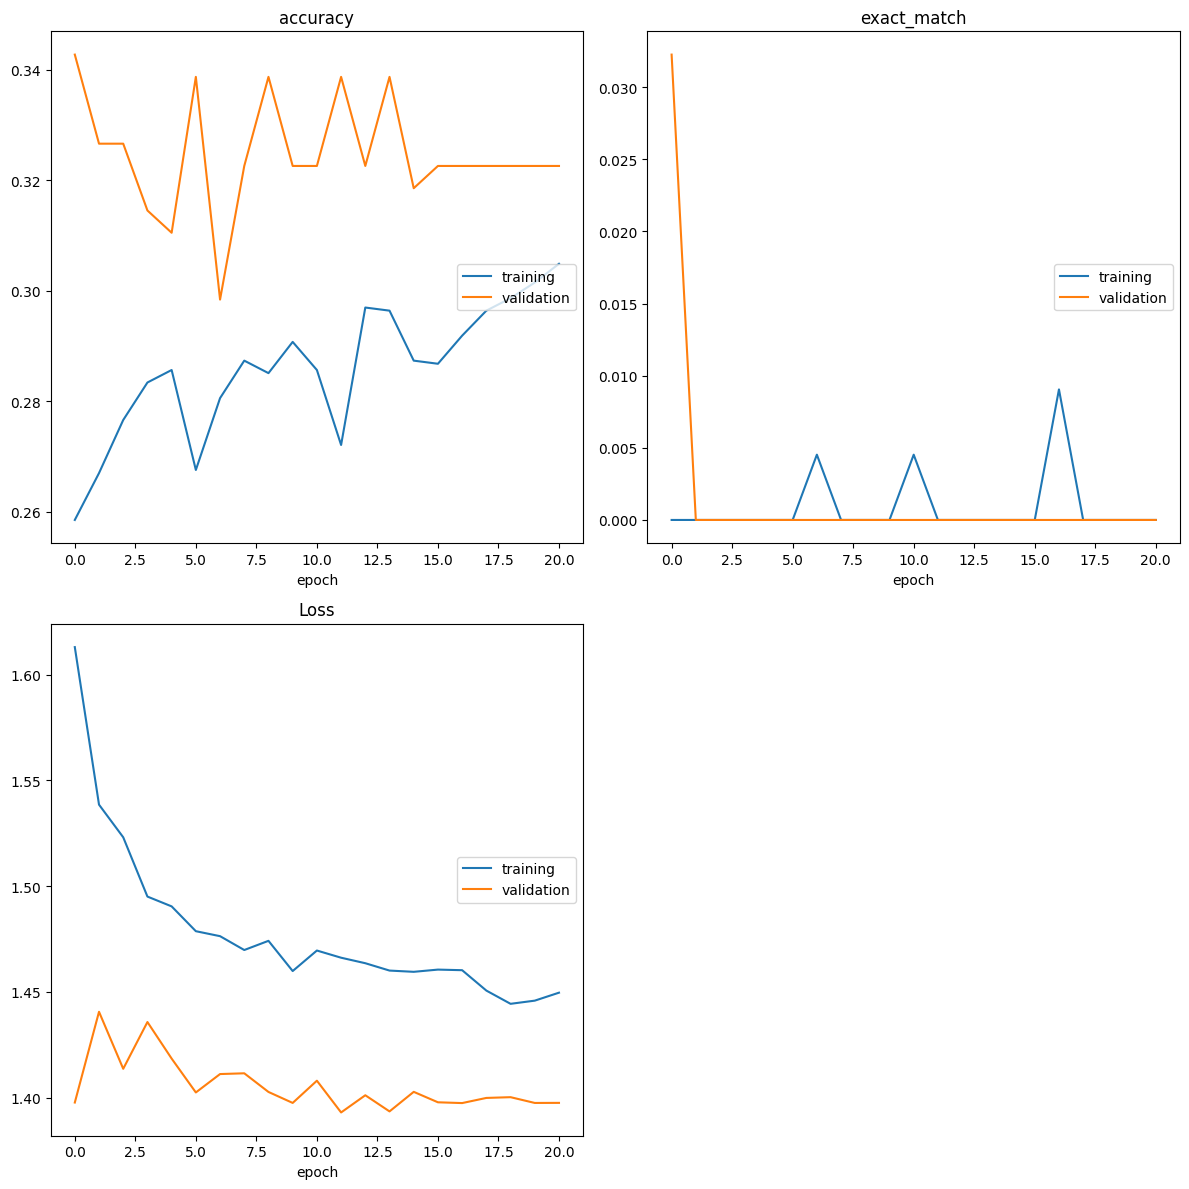

accuracy
	training         	 (min:    0.258, max:    0.305, cur:    0.305)
	validation       	 (min:    0.298, max:    0.343, cur:    0.323)
exact_match
	training         	 (min:    0.000, max:    0.009, cur:    0.000)
	validation       	 (min:    0.000, max:    0.032, cur:    0.000)
Loss
	training         	 (min:    1.444, max:    1.613, cur:    1.450)
	validation       	 (min:    1.393, max:    1.441, cur:    1.398)
EarlyStopping counter: 10/10
Early stopping activated.


In [37]:
train_model(
    model=model,
    model_path="osats_02.pth",
    train_dl=train_dl,
    val_dl=val_dl,
    criterion=CRITERION,
    optimizer=OPTIMIZER,
    scheduler=SCHEDULER,
    early_stopper = early_stopper,
    device=device,
    num_epochs=EPOCHS
)

### 5. Model Evaluation

#### Calculated Metrics
 - F1-Score
 - Accuracy
 - Expected Cost

In [48]:
# Export Ground Truth
video_ids, labels = [], []

for _, label_tensor, video_name in test_dl_all.dataset:
    video_ids.append(video_name)
    labels.append((label_tensor + 1).tolist())

labels_matrix = pd.DataFrame(labels, columns=[
    "OSATS_RESPECT", "OSATS_MOTION", "OSATS_INSTRUMENT", "OSATS_SUTURE",
    "OSATS_FLOW", "OSATS_KNOWLEDGE", "OSATS_PERFORMANCE", "OSATSFINALQUALITY"
])

df = pd.concat([pd.Series(video_ids, name="VIDEO"), labels_matrix], axis=1)

output_path = os.path.join(OUTPUT_FOLDER, "ground_truth.csv")
df.to_csv(output_path, index=False)
print(f"Saved ground truth to {output_path}")

Saved ground truth to ./results/ground_truth.csv


In [38]:
def predict_and_export_csv(model_path: str, dataloader, model_class, model_name: str, batch_size: int = 8):
    model = model_class().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Extrair dataset e índices do DataLoader
    if isinstance(dataloader.dataset, torch.utils.data.Subset):
        base_dataset = dataloader.dataset.dataset
        indices = dataloader.dataset.indices
    else:
        base_dataset = dataloader.dataset
        indices = list(range(len(base_dataset)))

    # Criar novo DataLoader com batch size pequeno
    subset = torch.utils.data.Subset(base_dataset, indices)
    small_loader = DataLoader(
        dataset=subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    results = []

    with torch.no_grad():
        for inputs, _, video_names in small_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)  # (B, 8, 5)
            _, predicted = torch.max(outputs, dim=2)  # (B, 8)
            predicted = (predicted.cpu().numpy() + 1).tolist()

            for name, pred in zip(video_names, predicted):
                results.append([name] + pred)

            del inputs, outputs, predicted
            torch.cuda.empty_cache()

    columns = ["VIDEO", "OSATS_RESPECT", "OSATS_MOTION", "OSATS_INSTRUMENT", "OSATS_SUTURE",
               "OSATS_FLOW", "OSATS_KNOWLEDGE", "OSATS_PERFORMANCE", "OSATSFINALQUALITY"]

    df = pd.DataFrame(results, columns=columns)
    output_path = os.path.join(OUTPUT_FOLDER, f"{model_name}_results.csv")
    df.to_csv(output_path, index=False)
    print(f"Saved OSATS predictions to {output_path}")

In [39]:
predict_and_export_csv(model_path="osats_02.pth", dataloader=test_dl_all, model_class=OSATSModel_02, model_name="osats_02")

Saved OSATS predictions to ./results/osats_02_results.csv



🔹 OSATS_RESPECT — F1-score (macro / DSC): 0.1048
🔹 OSATS_RESPECT — Expected Cost: 0.6774


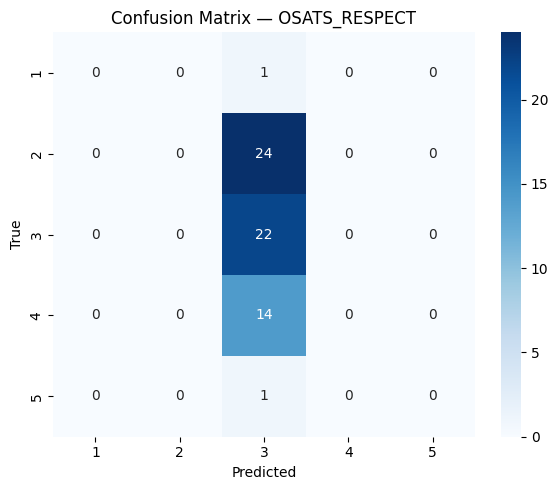


🔹 OSATS_MOTION — F1-score (macro / DSC): 0.1220
🔹 OSATS_MOTION — Expected Cost: 0.9032


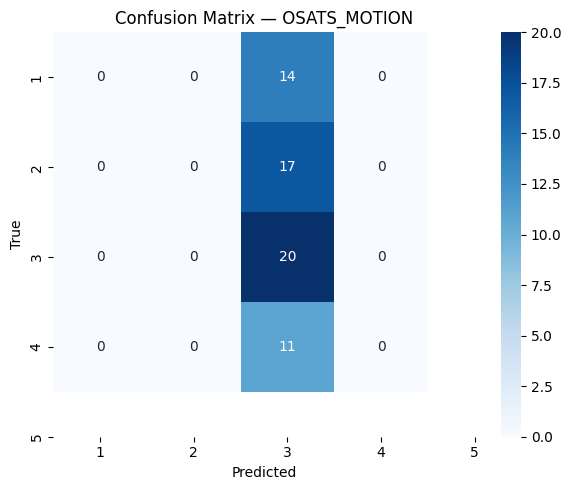


🔹 OSATS_INSTRUMENT — F1-score (macro / DSC): 0.1310
🔹 OSATS_INSTRUMENT — Expected Cost: 0.9355


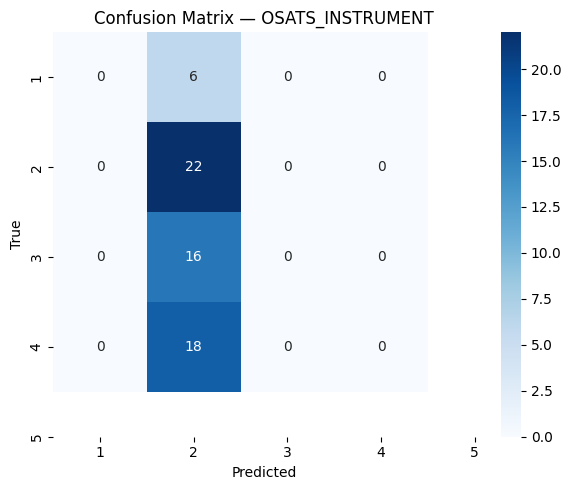


🔹 OSATS_SUTURE — F1-score (macro / DSC): 0.0938
🔹 OSATS_SUTURE — Expected Cost: 0.9194


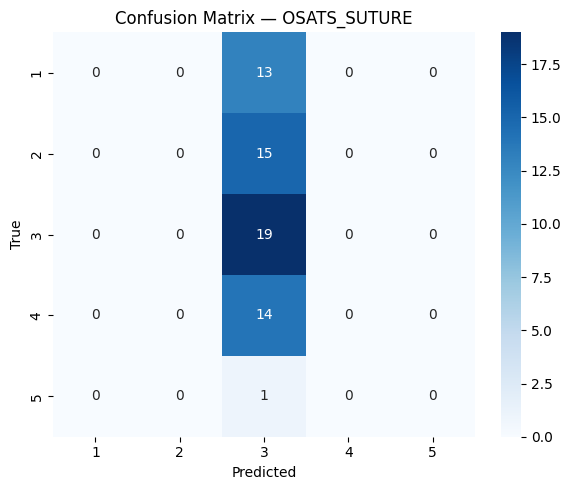


🔹 OSATS_FLOW — F1-score (macro / DSC): 0.1353
🔹 OSATS_FLOW — Expected Cost: 0.8387


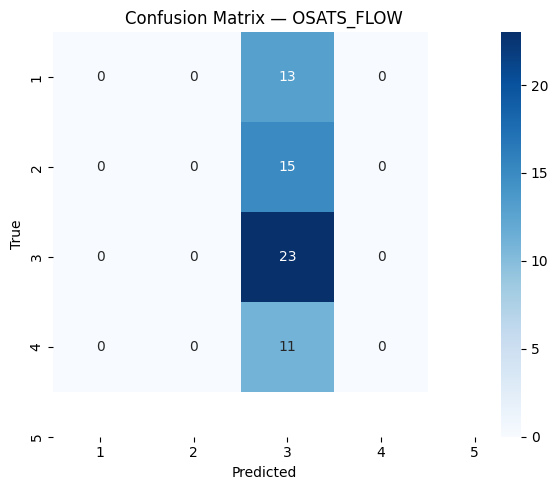


🔹 OSATS_KNOWLEDGE — F1-score (macro / DSC): 0.0976
🔹 OSATS_KNOWLEDGE — Expected Cost: 1.2419


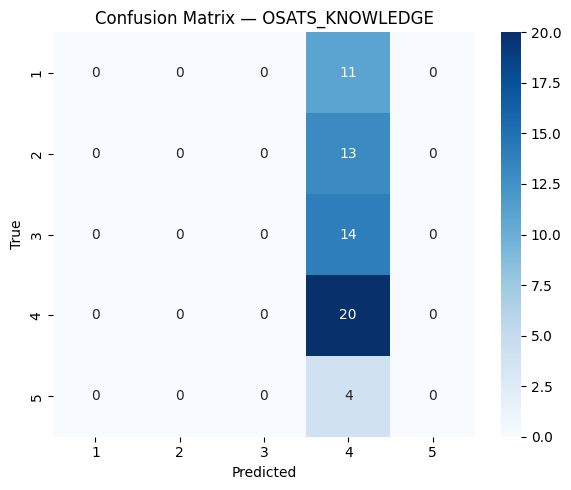


🔹 OSATS_PERFORMANCE — F1-score (macro / DSC): 0.1012
🔹 OSATS_PERFORMANCE — Expected Cost: 0.9194


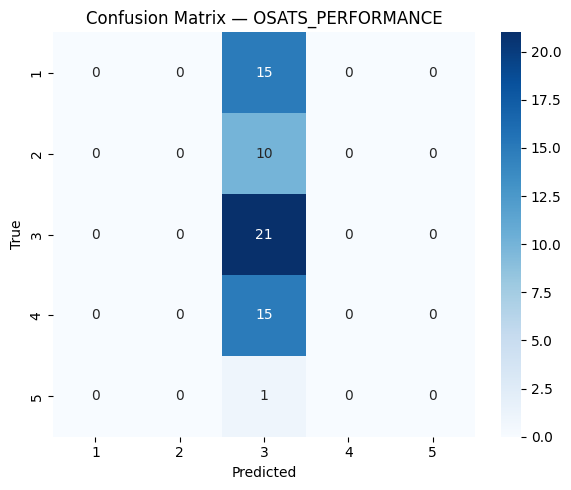


🔹 OSATSFINALQUALITY — F1-score (macro / DSC): 0.0821
🔹 OSATSFINALQUALITY — Expected Cost: 1.5806


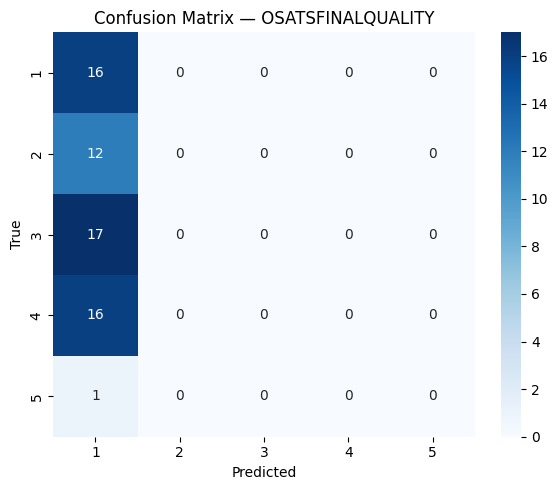

In [ ]:
GROUND_TRUTH_PATH = "results/ground_truth.csv"
PREDICTIONS_PATH = "results/osats_02_results.csv"
NUM_CLASSES = 5

df_gt = pd.read_csv(GROUND_TRUTH_PATH)
df_pred = pd.read_csv(PREDICTIONS_PATH)

# Merge
df = pd.merge(df_gt, df_pred, on="VIDEO", suffixes=('_gt', '_pred'))

osats_criteria = [
    "OSATS_RESPECT", "OSATS_MOTION", "OSATS_INSTRUMENT", "OSATS_SUTURE",
    "OSATS_FLOW", "OSATS_KNOWLEDGE", "OSATS_PERFORMANCE", "OSATSFINALQUALITY"
]

for criterion in osats_criteria:
    gt_col = f"{criterion}_gt"
    pred_col = f"{criterion}_pred"

    # 1–5 → 0–4
    df[[gt_col, pred_col]] = df[[gt_col, pred_col]] - 1

    # F1 macro
    f1 = f1_score(df[gt_col], df[pred_col], average='macro')
    print(f"\n🔹 {criterion} — F1-score (macro / DSC): {f1:.4f}")

    # Expected Cost
    cost_matrix = [[abs(i - j) for j in range(NUM_CLASSES)] for i in range(NUM_CLASSES)]
    expected_cost = np.mean([
        cost_matrix[gt][pred]
        for gt, pred in zip(df[gt_col], df[pred_col])
    ])
    print(f"🔹 {criterion} — Expected Cost: {expected_cost:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(df[gt_col], df[pred_col])
    class_names = ["1", "2", "3", "4", "5"]

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix — {criterion}")
    plt.tight_layout()
    plt.show()

In [ ]:
# Calcular Exact Match
gt_matrix = df[[f"{c}_gt" for c in osats_criteria]].values
pred_matrix = df[[f"{c}_pred" for c in osats_criteria]].values
exact_match = np.all(gt_matrix == pred_matrix, axis=1).astype(int)  # 1 = match, 0 = mismatch

accuracy = exact_match.mean()
print(f"\nExact Match Accuracy (todos os 8 critérios corretos): {accuracy:.4f}")

cm = confusion_matrix(exact_match, exact_match, labels=[0, 1])
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=["Mismatch", "Exact Match"], yticklabels=["Mismatch", "Exact Match"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Exact Match Confusion Matrix")
plt.tight_layout()
plt.show()